# Ensembling of CNN models

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.ensemble import VotingClassifier

efficientnet = load_model('/kaggle/input/classification-big-models/effnetraw.h5')
inception = load_model('/kaggle/input/classification-big-models/inception.h5')
mobilenet = load_model('/kaggle/input/classification-big-models/mobilenetrawdata.h5')
resnet = load_model('/kaggle/input/classification-big-models/resnetraw.h5')
best = tf.saved_model.load('/kaggle/input/classification-big-models/best.torchscript')

models = [('efficientnet', efficientnet),
          ('inception', inception),
          ('mobilenet', mobilenet),
          ('resnet', resnet),
          ('best', best)]

voting_clf = VotingClassifier(models, voting='soft')

test_datagen = ImageDataGenerator(rescale=1./255)

test_data_dir = '/kaggle/input/clasificare2/test'
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

predictions = voting_clf.predict(test_generator)

np.savetxt('predictions.csv', predictions, delimiter=',')


In [4]:
import numpy as np
import tensorflow as tf
import xgboost as xgb
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
from scipy.stats import mode
import os
import tensorflow as tf
# from ultralytics import YOLO
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess_input

inception = tf.keras.models.load_model("/kaggle/input/classification-big-models/inception.h5")
mobilenet = tf.keras.models.load_model("/kaggle/input/classification-big-models/mobilenetrawdata.h5")
efficientnet = tf.saved_model.load("/kaggle/input/classification-big-models")
resnet = tf.keras.models.load_model("/kaggle/input/classification-big-models/resnetraw.h5")
# yolov8 = YOLO('/kaggle/input/classification-big-models/best.pt')
# best = yolov8 

models = [
    ("resnet", resnet),
    ("efficientnet", efficientnet),
    ("mobilenet", mobilenet),
    ("inception", inception),
#     ("best", best)
]

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory("/kaggle/input/clasificare2/clasificare2/train", target_size=(224, 224), batch_size=32, class_mode="categorical")
val_generator = train_datagen.flow_from_directory("/kaggle/input/clasificare2/clasificare2/val", target_size=(224, 224), batch_size=32, class_mode="categorical")
test_generator = test_datagen.flow_from_directory("/kaggle/input/classification-big-test/classification_big_test", target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False)

train_y = train_generator.labels
val_y = val_generator.labels



def train_xgboost(meta_train_data, train_y):
    xgb_model = xgb.XGBClassifier(n_jobs=-1)
    xgb_model.fit(meta_train_data, train_y)

def get_individual_model_predictions(models, generator, dataset_dir):
    all_predictions = []
    all_probabilities=[]
    print(dataset_dir)
    for model_name, model in models:
        print(model_name)
        model_predictions = []
        model_probabilities = [] 
        for filename in generator.filenames:
            file_path = os.path.join(dataset_dir, filename)
            img = cv2.imread(file_path)
            img = cv2.resize(img, (224, 224))
            img = img.astype(np.float32)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            img = img / 255.0
            if model_name == 'inception':
                img = inception_preprocess_input(img * 255.0)
                img_resized = tf.image.resize(np.expand_dims(img, axis=0), (299, 299))
            elif model_name == 'best':
                img_resized = cv2.resize(img, (640, 640))
                img_resized = cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR)
            else:
                if model_name == 'mobilenet':
                    img = mobilenet_preprocess_input(img * 255.0)
                elif model_name == 'efficientnet':
                    img = efficientnet_preprocess_input(img * 255.0)
                elif model_name == 'resnet':
                    img = resnet_preprocess_input(img * 255.0)
                img_resized = np.expand_dims(img, axis=0)

            if isinstance(model, type(efficientnet)):
                model_prediction = model.signatures['serving_default'](tf.constant(img_resized))
                model_prediction = model_prediction['dense_2'].numpy()
            elif model_name == 'best':  # YOLOv8 model
                model_prediction = model(file_path)[0].probs.cpu().numpy()
            else:
                model_prediction = model.predict(img_resized, verbose=0)
            if model_name == 'best':  # YOLOv8 model
                model_probabilities.append(model_prediction.squeeze())
            else:
                model_probabilities.append(model_prediction.squeeze()[:3])

            #model_probabilities.append(model_prediction.squeeze())
            model_predictions.append(np.argmax(model_prediction))

        all_predictions.append(np.array(model_predictions))
        all_probabilities.append(np.array(model_probabilities))

     # Voting classifier
    all_probabilities_array = np.stack(all_probabilities, axis=1)
    all_predictions_array = np.array(all_predictions)
    voting_predictions, _ = mode(all_predictions_array, axis=0)
    voting_predictions = voting_predictions.squeeze()

    return all_predictions, voting_predictions, all_probabilities_array


train_individual_predictions, voting_preds_train, all_probabilities_array_train = get_individual_model_predictions(models, train_generator, "/kaggle/input/clasificare2/clasificare2/train")
val_individual_predictions, voting_preds_val, all_probabilities_array_val = get_individual_model_predictions(models, val_generator, "/kaggle/input/clasificare2/clasificare2/val")
test_individual_predictions, voting_preds, all_probabilities_array = get_individual_model_predictions(models, test_generator, "/kaggle/input/classification-big-test/classification_big_test")

Found 2880 images belonging to 3 classes.
Found 360 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.
/kaggle/input/clasificare2/clasificare2/train
resnet
efficientnet
mobilenet
inception
/kaggle/input/clasificare2/clasificare2/val
resnet
efficientnet
mobilenet
inception
/kaggle/input/classification-big-test/classification_big_test
resnet
efficientnet
mobilenet
inception


In [5]:
print(all_probabilities_array)

[[[9.7978437e-01 1.0509094e-03 1.9163629e-02]
  [9.7326261e-01 2.3953985e-02 2.7826368e-03]
  [7.6330030e-01 1.9976196e-01 3.6936276e-02]
  [9.7563249e-01 3.2935902e-03 2.1073153e-02]]

 [[6.3287467e-01 1.4216551e-03 3.6570212e-01]
  [3.4472850e-01 8.2103973e-03 6.4706028e-01]
  [2.2440258e-01 8.0358826e-02 6.9523805e-01]
  [5.9409559e-01 1.2457534e-04 4.0577865e-01]]

 [[9.1230184e-01 6.9541290e-02 1.8152859e-02]
  [7.7928799e-01 1.6306618e-01 5.7645265e-02]
  [2.2237575e-01 7.7720219e-01 4.2209931e-04]
  [9.5949548e-01 3.4159064e-02 6.3436828e-03]]

 ...

 [[6.7373231e-02 7.1821756e-05 9.3255466e-01]
  [3.6821980e-02 4.3265609e-04 9.6274489e-01]
  [2.6680084e-02 3.7116325e-04 9.7294790e-01]
  [2.4847224e-02 4.7485190e-07 9.7515196e-01]]

 [[7.4498248e-01 3.9041569e-03 2.5111008e-01]
  [8.0539387e-01 5.3962454e-02 1.4064279e-01]
  [7.5342560e-01 1.2857117e-01 1.1800177e-01]
  [7.5290859e-01 1.1850756e-03 2.4590407e-01]]

 [[7.2808617e-01 7.3644833e-04 2.7117690e-01]
  [4.6611109e-01 2

In [17]:
from sklearn.metrics import accuracy_score
average_probabilities = np.mean(all_probabilities_array, axis=1)

soft_voting_preds = np.argmax(average_probabilities, axis=1)

soft_voting_accuracy = accuracy_score(test_generator.classes, soft_voting_preds)
print(f"Soft voting accuracy: {soft_voting_accuracy}")


Soft voting accuracy: 0.8175


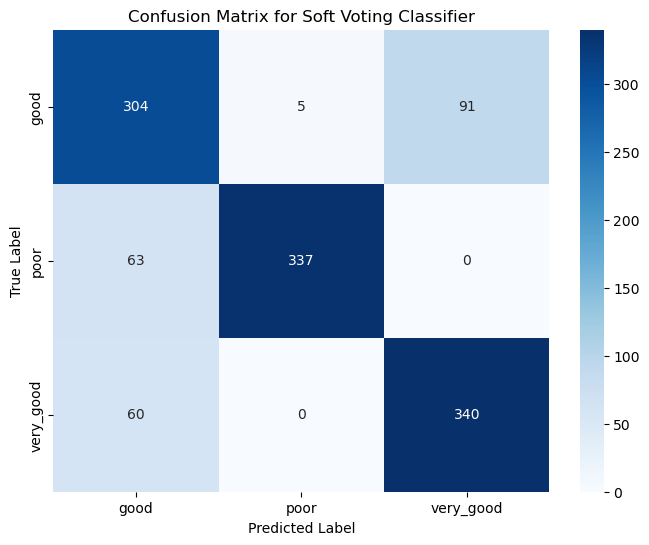

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_generator.classes, soft_voting_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Soft Voting Classifier')
plt.show()

In [20]:
from sklearn.metrics import accuracy_score
true_labels = test_generator.labels
voting_accuracy = accuracy_score(true_labels, voting_preds)

print(f"Voting classifier accuracy: {voting_accuracy}")


Voting classifier accuracy: 0.8


[[328   3  69]
 [ 79 321   0]
 [ 89   0 311]]


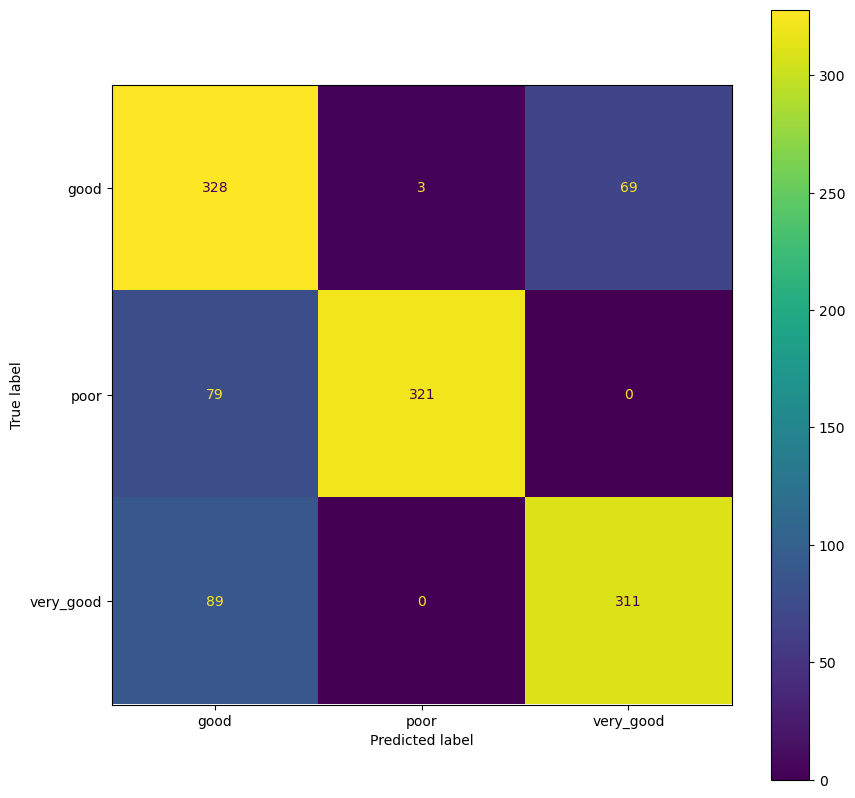

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, voting_preds)
print(cm)

class_names = list(test_generator.class_indices.keys())

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax)
plt.show()

# XGBoost meta on probabilities

In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Train XGBoost with probabilities
train_y_full = np.concatenate((train_y, val_y))
xgb_model_probs = train_xgboost(meta_train_data_probs_reshaped, train_y_full)
xgb_predictions_probs = xgb_model_probs.predict(meta_test_data_probs_reshaped)
test_y = test_generator.labels
accuracy_probs = accuracy_score(test_y, xgb_predictions_probs)
print("Accuracy: {:.2f}%".format(accuracy_probs * 100))

cm_probs = confusion_matrix(test_y, xgb_predictions_probs)
print(cm_probs)

fig, ax = plt.subplots(figsize=(10, 10))
disp_probs = ConfusionMatrixDisplay(confusion_matrix=cm_probs)
disp_probs.plot(ax=ax)
plt.show()

In [25]:
print(xgb_predictions_probs)

[0 0 0 ... 2 0 0]


In [7]:
print(test_individual_predictions)

[array([0, 0, 0, ..., 2, 0, 0]), array([0, 2, 0, ..., 2, 0, 0]), array([0, 2, 1, ..., 2, 0, 2]), array([0, 0, 0, ..., 2, 0, 0]), array([0, 0, 0, ..., 2, 2, 2])]


In [10]:
from xgboost import XGBClassifier
def train_xgboost(X, y):
    xgb_clf = XGBClassifier(
        n_jobs=-1,
        random_state=42,
        objective='multi:softmax',
        eval_metric='mlogloss',
        use_label_encoder=False
    )

    xgb_clf.fit(X, y)
    return xgb_clf  
xgb_model = train_xgboost(meta_train_data, train_y)
xgb_predictions = xgb_model.predict(meta_test_data)

Accuracy: 83.33%
[[354  11  35]
 [ 46 354   0]
 [108   0 292]]


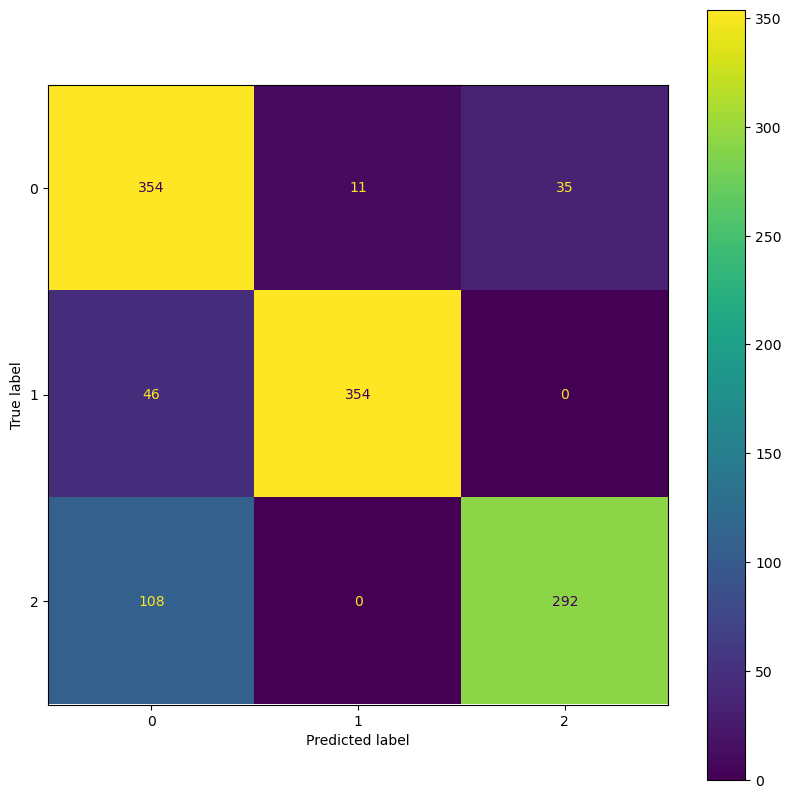

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
test_y = test_generator.labels
accuracy = accuracy_score(test_y, xgb_predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

cm = confusion_matrix(test_y, xgb_predictions)
print(cm)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()


# Accuracies on models for big test set vs truth

Accuracy of Base Model 1: 0.79
Confusion matrix:
 [[322   4  74]
 [ 73 327   0]
 [100   0 300]]


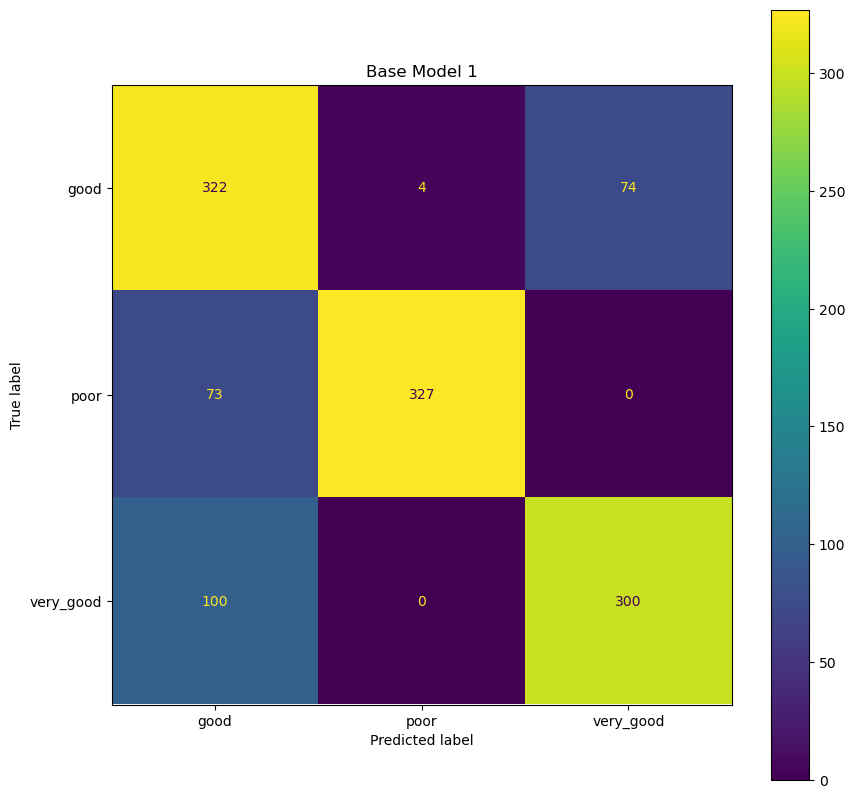

Accuracy of Base Model 2: 0.82
Confusion matrix:
 [[323  21  56]
 [ 69 331   0]
 [ 73   0 327]]


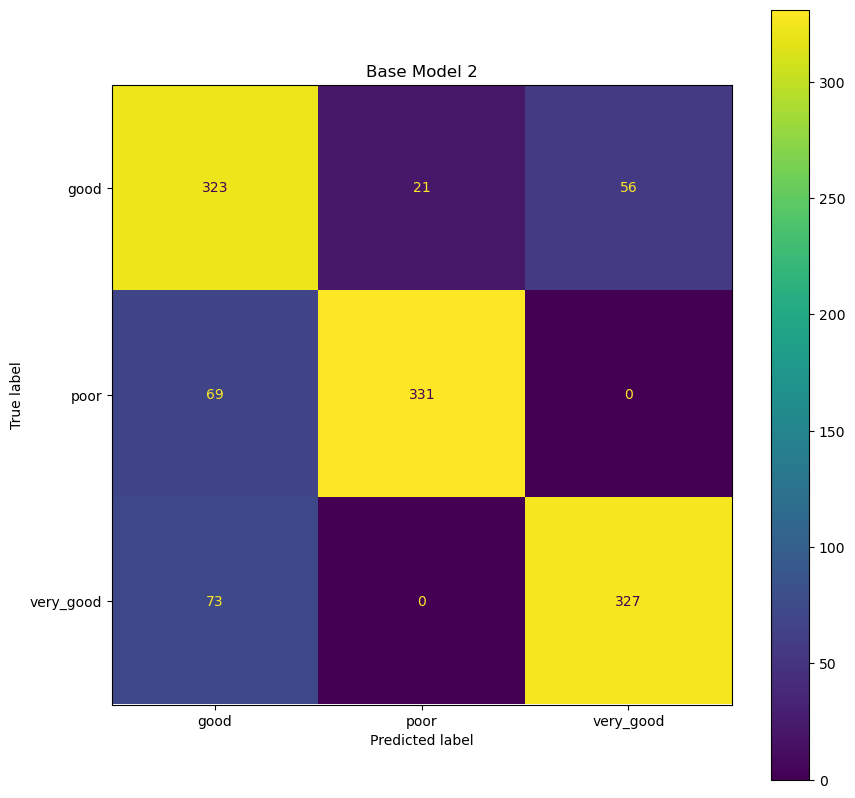

Accuracy of Base Model 3: 0.73
Confusion matrix:
 [[208  69 123]
 [ 38 361   1]
 [ 95   1 304]]


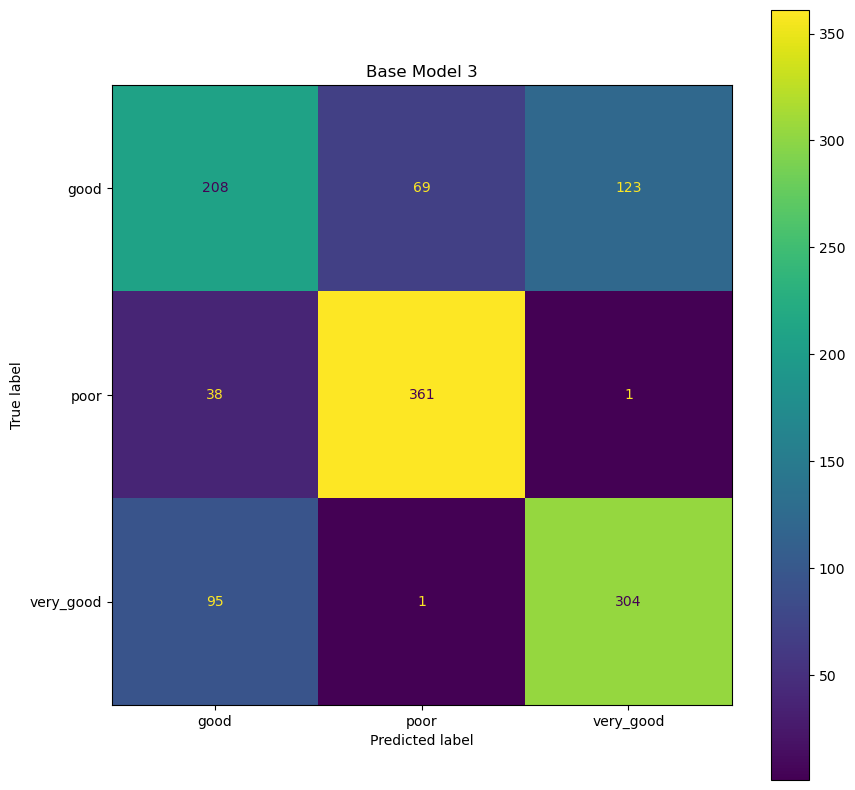

Accuracy of Base Model 4: 0.77
Confusion matrix:
 [[274   1 125]
 [ 94 306   0]
 [ 53   0 347]]


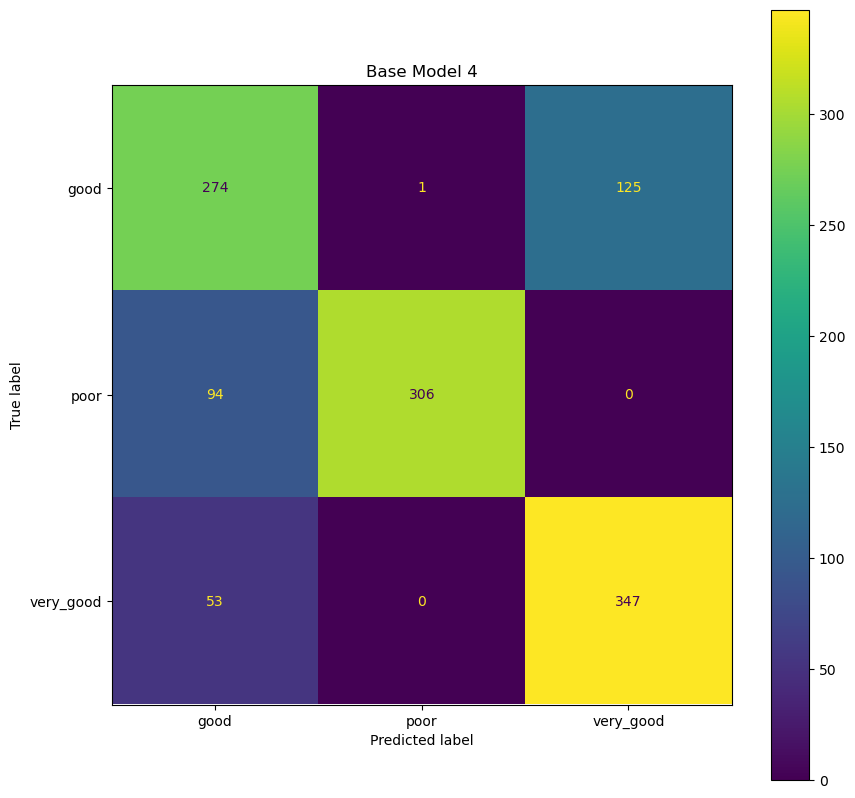

In [15]:
from sklearn.metrics import accuracy_score

for i, base_model_preds in enumerate(test_individual_predictions):
    accuracy = accuracy_score(true_labels, base_model_preds)
    print(f"Accuracy of Base Model {i + 1}: {accuracy:.2f}")

    cm = confusion_matrix(true_labels, base_model_preds)
    np.set_printoptions(precision=2)
    print("Confusion matrix:\n", cm)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax)
    plt.title(f"Base Model {i + 1}")
    plt.show()



Confusion matrix:
 [[329   4  72]
 [ 73 327   0]
 [ 93   0 302]]


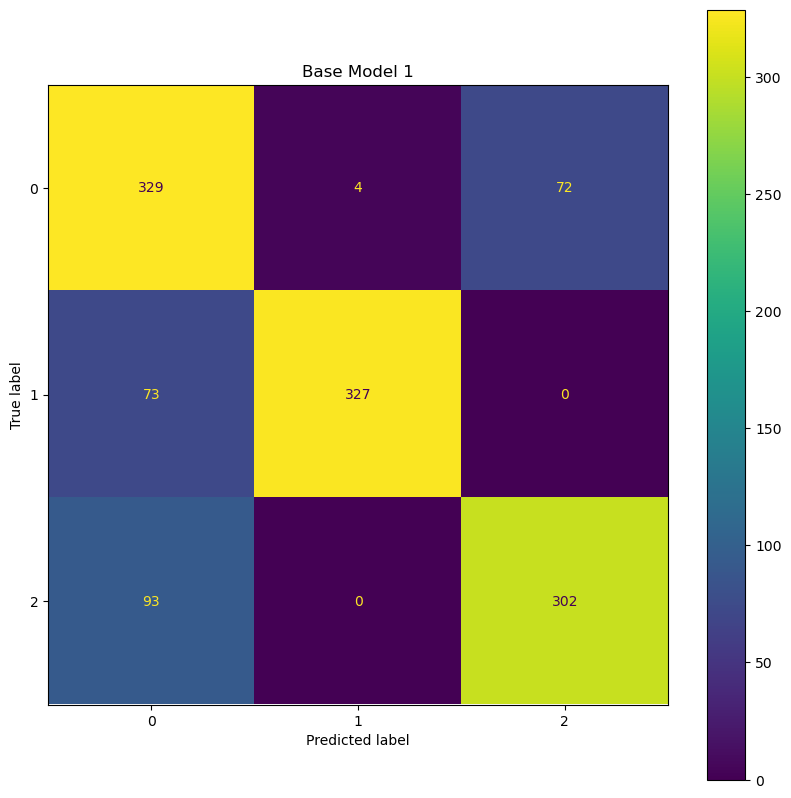

Confusion matrix:
 [[329  21  55]
 [ 69 331   0]
 [ 67   0 328]]


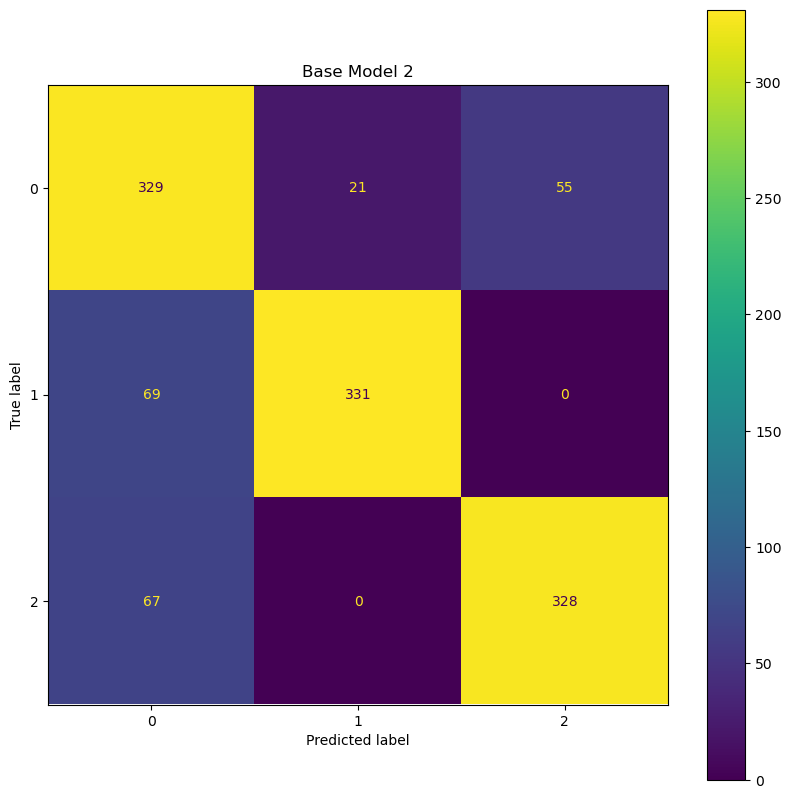

Confusion matrix:
 [[215  70 120]
 [ 38 361   1]
 [ 88   0 307]]


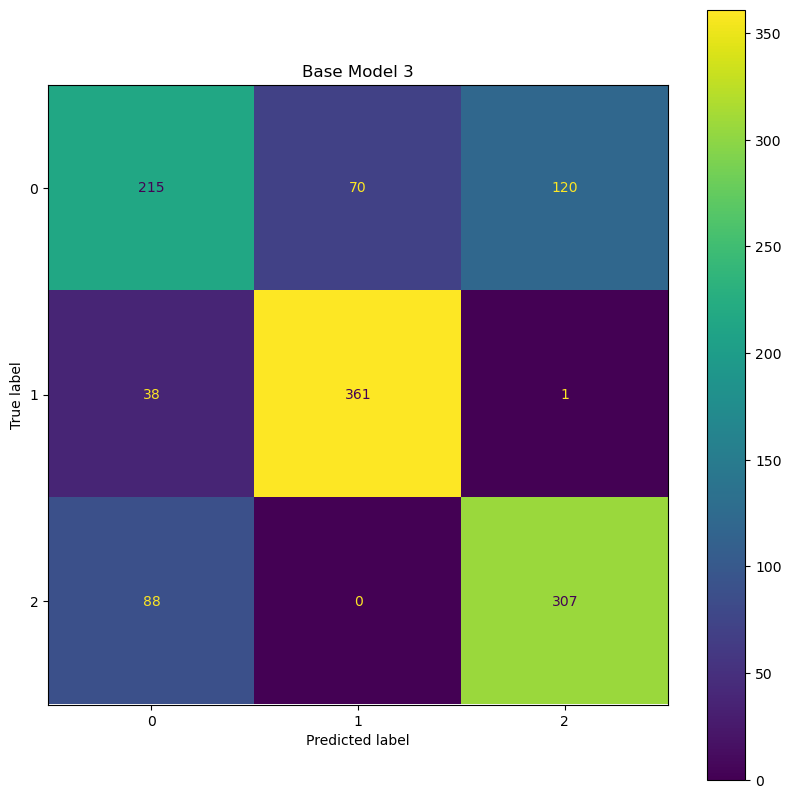

Confusion matrix:
 [[281   1 123]
 [ 94 306   0]
 [ 46   0 349]]


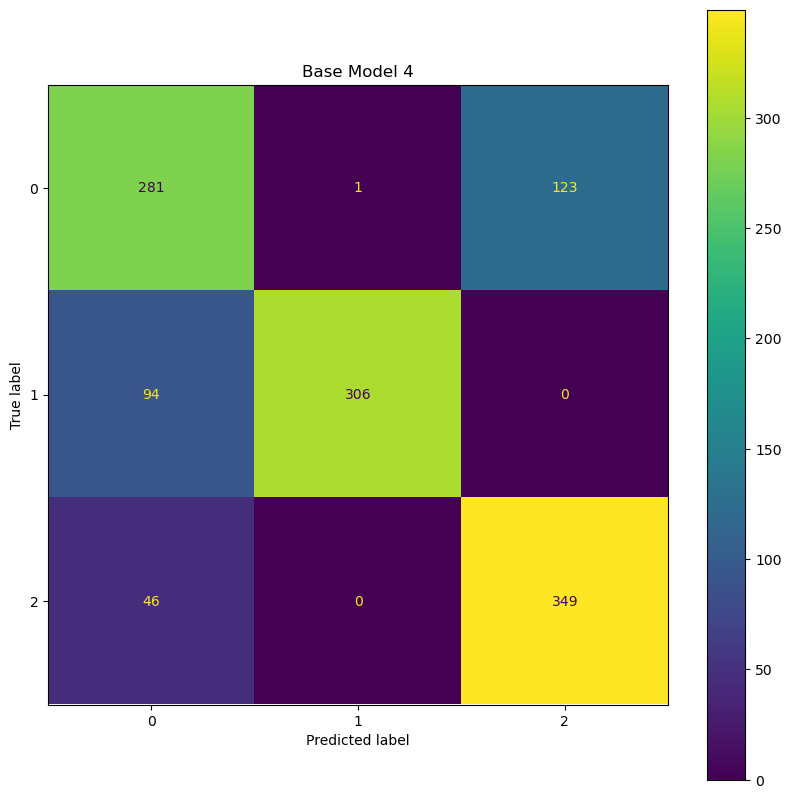

Confusion matrix:
 [[405   0   0]
 [  0 400   0]
 [  0   0 395]]


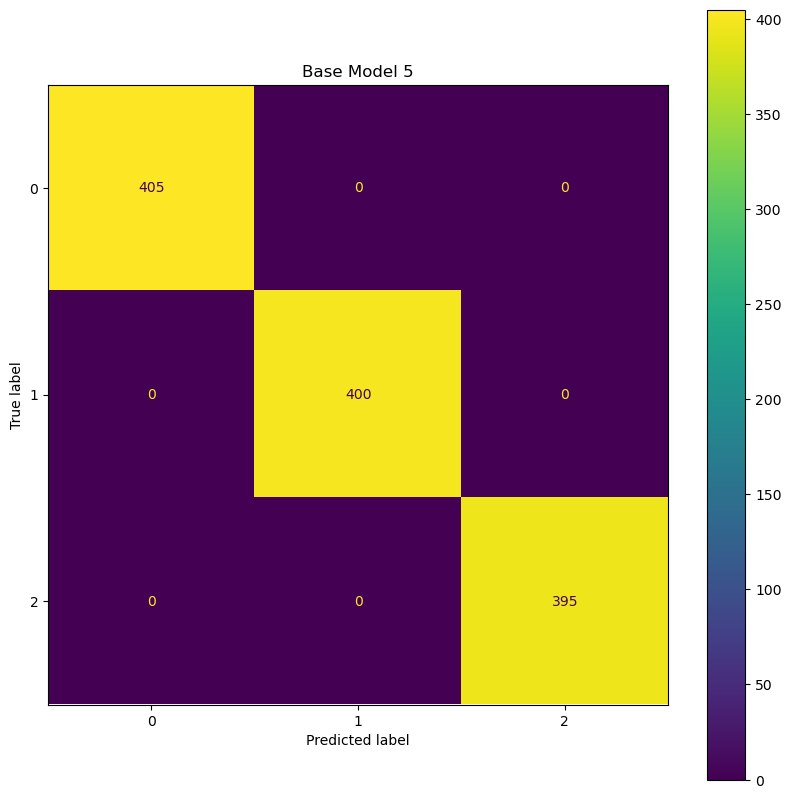

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for i, base_model_preds in enumerate(test_individual_predictions):
    cm = confusion_matrix(xgb_predictions, base_model_preds)
    np.set_printoptions(precision=2)
    print("Confusion matrix:\n", cm)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax)
    plt.title(f"Base Model {i + 1}")
    plt.show()


# AdaBoost meta on probabilities

Accuracy: 80.42%


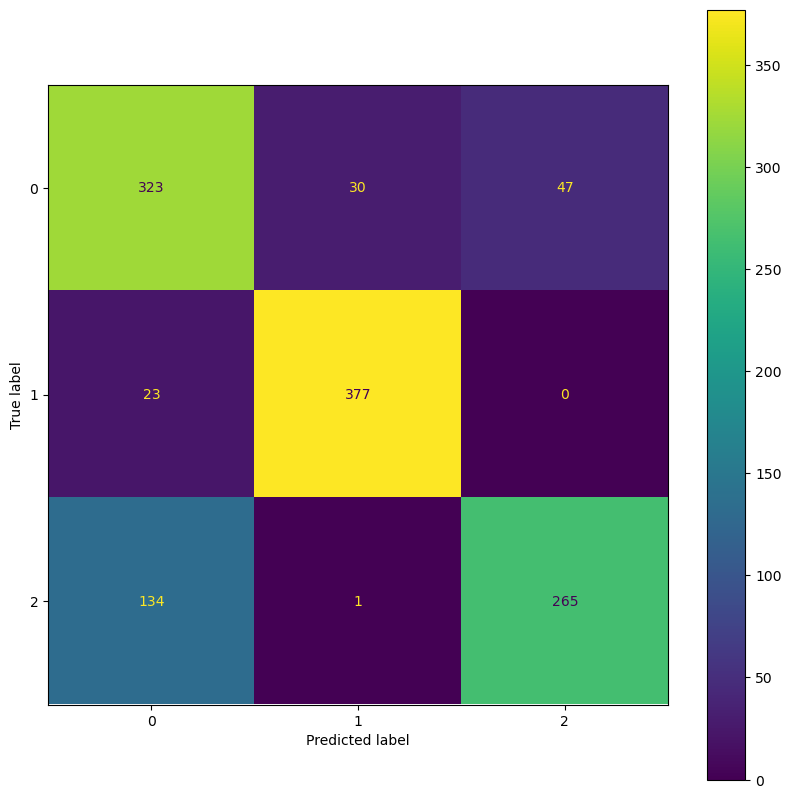

[[323  30  47]
 [ 23 377   0]
 [134   1 265]]


In [30]:
from sklearn.ensemble import AdaBoostClassifier

def train_adaboost(X, y):
    ada_clf = AdaBoostClassifier(
        n_estimators=100,
        learning_rate=1,
        random_state=42
    )

    ada_clf.fit(X, y)
    return ada_clf

ada_model = train_adaboost(meta_train_data_probs_reshaped, train_y)
ada_predictions = ada_model.predict(meta_test_data_probs_reshaped)
test_y = test_generator.labels
accuracy = accuracy_score(test_y, ada_predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

cm = confusion_matrix(test_y, ada_predictions)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()
print(cm)

# Adaboost meta on predictions

Accuracy: 61.75%


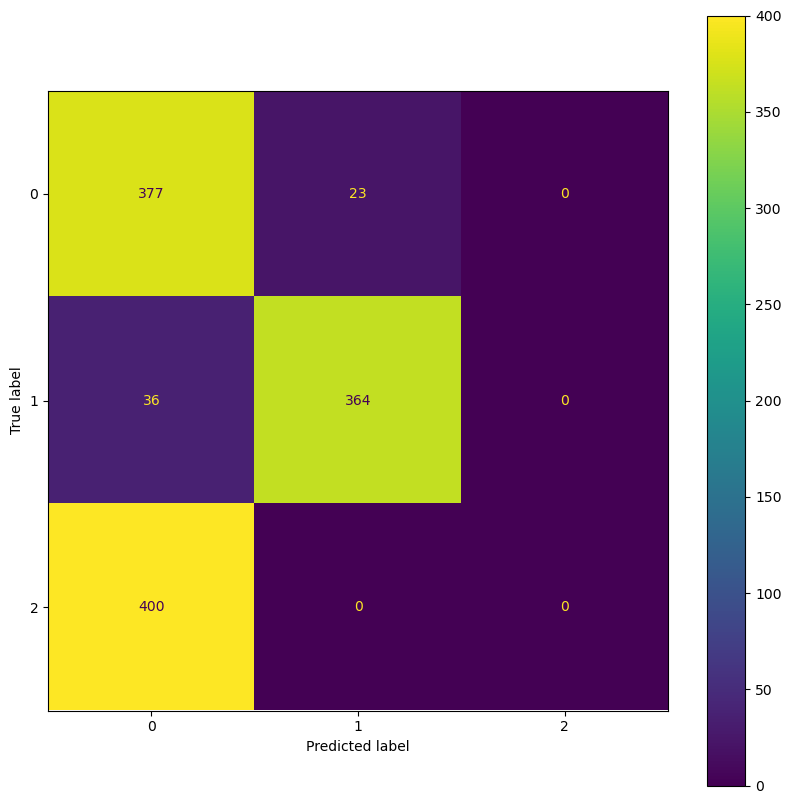

[[377  23   0]
 [ 36 364   0]
 [400   0   0]]


In [33]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
train_individual_predictions_stacked = np.column_stack(train_individual_predictions)
val_individual_predictions_stacked = np.column_stack(val_individual_predictions)

meta_train_data = np.vstack((train_individual_predictions_stacked, val_individual_predictions_stacked))
meta_test_data = np.column_stack(test_individual_predictions)

train_y = np.concatenate([train_generator.labels, val_generator.labels])
test_y = test_generator.labels

from sklearn.ensemble import AdaBoostClassifier

def train_adaboost(X, y):
    ada_clf = AdaBoostClassifier(
        n_estimators=100,
        learning_rate=1,
        random_state=42
    )

    ada_clf.fit(X, y)
    return ada_clf

ada_model = train_adaboost(meta_train_data, train_y)
ada_predictions = ada_model.predict(meta_test_data)
test_y = test_generator.labels
accuracy = accuracy_score(test_y, ada_predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

cm = confusion_matrix(test_y, ada_predictions)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()
print(cm)

In [19]:
print("train_individual_predictions shape:", len(all_probabilities_array_train))
print("val_individual_predictions shape:", len(train_y_full))

train_individual_predictions shape: 2880
val_individual_predictions shape: 3600


# Random forest meta predictions

Accuracy: 83.33%


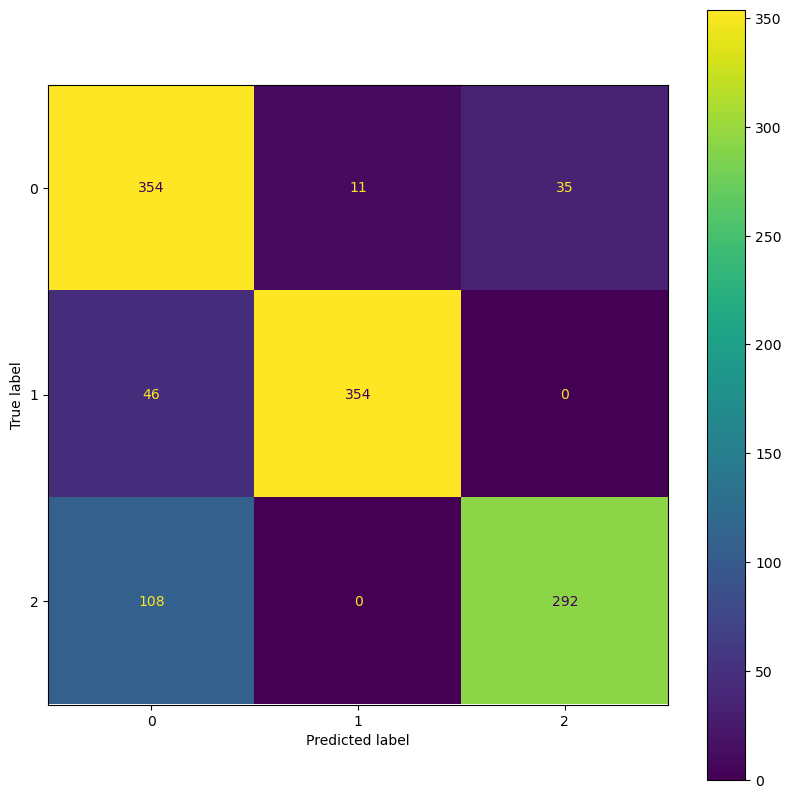

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
train_individual_predictions_stacked = np.column_stack(train_individual_predictions)
val_individual_predictions_stacked = np.column_stack(val_individual_predictions)

meta_train_data = np.vstack((train_individual_predictions_stacked, val_individual_predictions_stacked))
meta_test_data = np.column_stack(test_individual_predictions)

train_y = np.concatenate([train_generator.labels, val_generator.labels])
test_y = test_generator.labels
def train_random_forest(X, y):
    rf_clf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )

    rf_clf.fit(X, y)
    return rf_clf

rf_model = train_random_forest(meta_train_data, train_y)
rf_predictions = rf_model.predict(meta_test_data)

accuracy = accuracy_score(test_y, rf_predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

cm = confusion_matrix(test_y, rf_predictions)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()


# Random forest meta probabilities

Accuracy: 85.08%


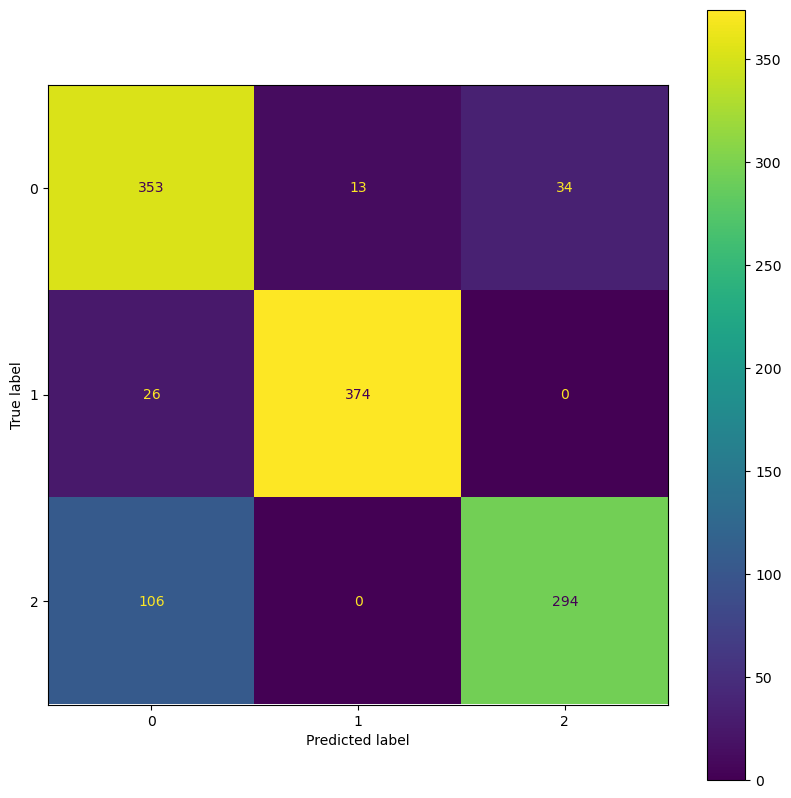

In [26]:
from sklearn.ensemble import RandomForestClassifier
train_y_full = np.concatenate((train_y, val_y))
meta_train_data_probs = np.concatenate((all_probabilities_array_train, all_probabilities_array_val), axis=0)
meta_test_data_probs = all_probabilities_array
meta_train_data_probs_reshaped = np.reshape(meta_train_data_probs, (meta_train_data_probs.shape[0], -1))
meta_test_data_probs_reshaped = np.reshape(meta_test_data_probs, (meta_test_data_probs.shape[0], -1))
def train_random_forest(X, y):
    rf_clf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )

    rf_clf.fit(X, y)
    return rf_clf

rf_model = train_random_forest(meta_train_data_probs_reshaped, train_y)
rf_predictions = rf_model.predict(meta_test_data_probs_reshaped)

accuracy = accuracy_score(test_y, rf_predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

cm = confusion_matrix(test_y, rf_predictions)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()


# Gradient boosting with probabilities

Accuracy: 84.75%


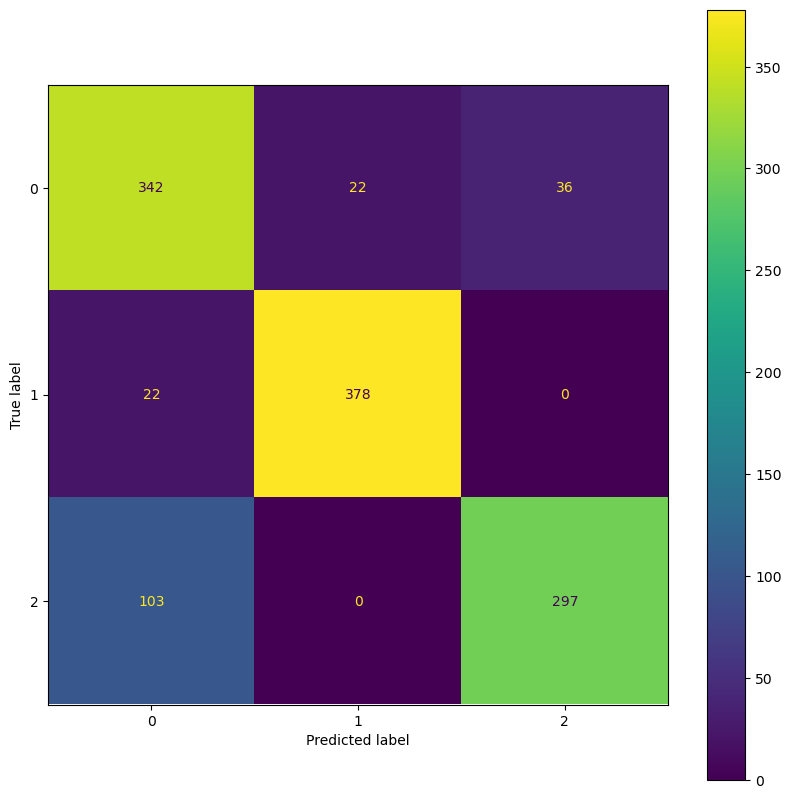

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

train_y_full = np.concatenate((train_y, val_y))
meta_train_data_probs = np.concatenate((all_probabilities_array_train, all_probabilities_array_val), axis=0)
meta_test_data_probs = all_probabilities_array
meta_train_data_probs_reshaped = np.reshape(meta_train_data_probs, (meta_train_data_probs.shape[0], -1))
meta_test_data_probs_reshaped = np.reshape(meta_test_data_probs, (meta_test_data_probs.shape[0], -1))

def train_gradient_boosting(X, y):
    gb_clf = GradientBoostingClassifier(
        n_estimators=100,
        random_state=42
    )

    gb_clf.fit(X, y)
    return gb_clf

gb_model = train_gradient_boosting(meta_train_data_probs_reshaped, train_y)
gb_predictions = gb_model.predict(meta_test_data_probs_reshaped)

accuracy = accuracy_score(test_y, gb_predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

cm = confusion_matrix(test_y, gb_predictions)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()


# Gradient boosting with predictions

Accuracy: 83.33%


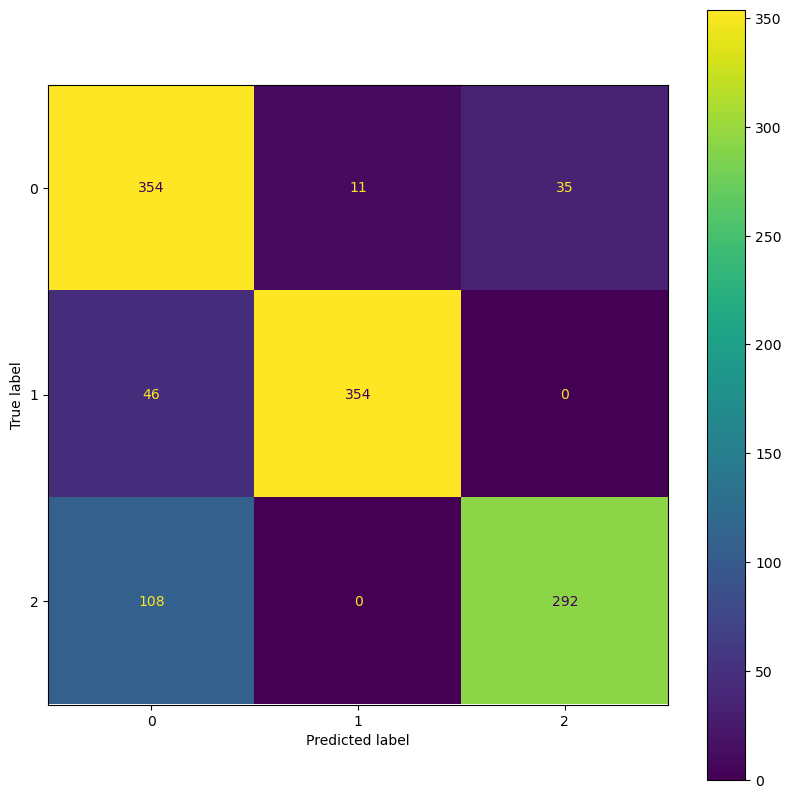

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
train_individual_predictions_stacked = np.column_stack(train_individual_predictions)
val_individual_predictions_stacked = np.column_stack(val_individual_predictions)

meta_train_data = np.vstack((train_individual_predictions_stacked, val_individual_predictions_stacked))
meta_test_data = np.column_stack(test_individual_predictions)

train_y = np.concatenate([train_generator.labels, val_generator.labels])
def train_gradient_boosting(X, y):
    gb_clf = GradientBoostingClassifier(
        n_estimators=100,
        random_state=42
    )

    gb_clf.fit(X, y)
    return gb_clf

gb_model = train_gradient_boosting(meta_train_data, train_y)
gb_predictions = gb_model.predict(meta_test_data)

accuracy = accuracy_score(test_y, gb_predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

cm = confusion_matrix(test_y, gb_predictions)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()


# SVM meta

Accuracy: 99.08%


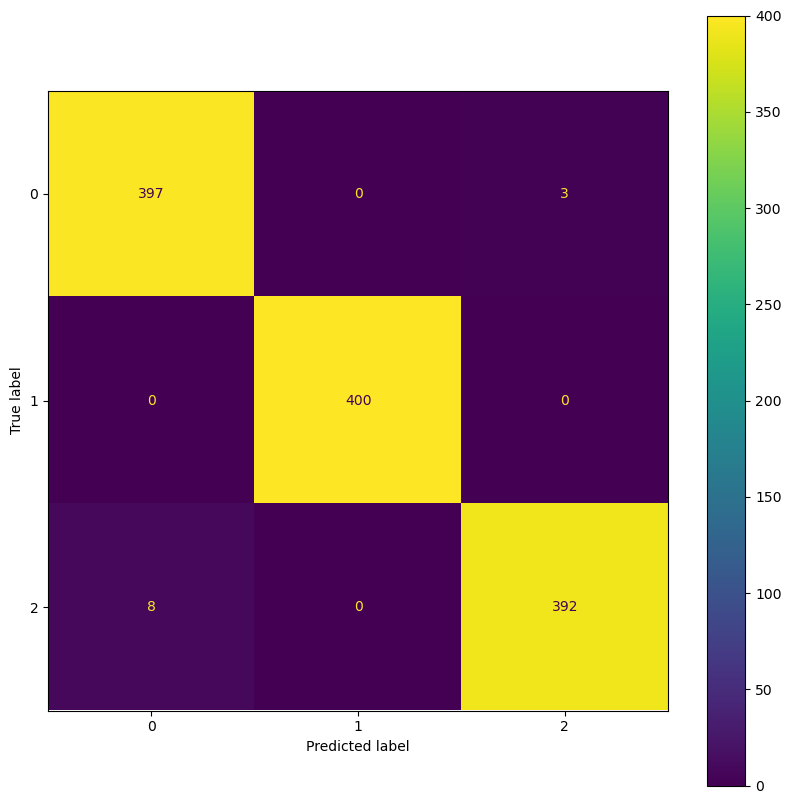

In [14]:
from sklearn.svm import SVC

def train_svm(X, y):
    svm_clf = SVC(
        C=1.0,
        kernel='rbf',
        gamma='scale',
        random_state=42
    )

    svm_clf.fit(X, y)
    return svm_clf

svm_model = train_svm(meta_train_data, train_y)
svm_predictions = svm_model.predict(meta_test_data)

accuracy = accuracy_score(test_y, svm_predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

cm = confusion_matrix(test_y, svm_predictions)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()


# Feature extraction

In [1]:
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input

train_dir = '/kaggle/input/clasificare2/clasificare2/train'
val_dir = '/kaggle/input/clasificare2/clasificare2/val'
test_dir = '/kaggle/input/clasificare2/clasificare2/test'

labels = ['very_good', 'good', 'poor']

#model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#from keras.applications.vgg16 import VGG16, preprocess_input
#model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
from keras.applications.resnet import ResNet50, preprocess_input
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

num_features = 50

train_features = []
train_class_labels = []
val_features = []
val_class_labels = []
test_features = []
test_class_labels = []

batch_size = 32

for class_label, class_name in enumerate(labels):
    for img_file in os.listdir(os.path.join(train_dir, class_name)):
        if img_file.endswith('.png'):
            img = load_img(os.path.join(train_dir, class_name, img_file), target_size=(224, 224))
            x = img_to_array(img)
            x = preprocess_input(x)

            features_raw = model.predict(np.array([x]))
            train_features.append(features_raw.flatten())

            train_class_labels.append(class_label)

for class_label, class_name in enumerate(labels):
    for img_file in os.listdir(os.path.join(val_dir, class_name)):
        if img_file.endswith('.png'):
            img = load_img(os.path.join(val_dir, class_name, img_file), target_size=(224, 224))
            x = img_to_array(img)
            x = preprocess_input(x)

            features_raw = model.predict(np.array([x]))
            val_features.append(features_raw.flatten())

            val_class_labels.append(class_label)

for class_label, class_name in enumerate(labels):
    for img_file in os.listdir(os.path.join(test_dir, class_name)):
        if img_file.endswith('.png'):
            img = load_img(os.path.join(test_dir, class_name, img_file), target_size=(224, 224))
            x = img_to_array(img)
            x = preprocess_input(x)

            features_raw = model.predict(np.array([x]))
            test_features.append(features_raw.flatten())

            test_class_labels.append(class_label)

# val_features, val_class_labels = extract_features_from_generator(val_generator, model, len(val_generator.filenames))
# test_features, test_class_labels = extract_features_from_generator(test_generator, model, len(test_generator.filenames))
# train_features, train_class_labels = extract_features_from_generator(train_generator, model, len(train_generator.filenames))


train_X = np.array(train_features)
train_y = np.array(train_class_labels)
val_X = np.array(val_features)
val_y = np.array(val_class_labels)
test_X = np.array(test_features)
test_y = np.array(test_class_labels)

selector = RFE


1/1 [==============================] - 0s 43ms/step


KeyboardInterrupt: 

In [2]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
#selector = SelectFromModel(estimator=RandomForestClassifier(n_jobs=-1), threshold="mean")
selector = SelectFromModel(ExtraTreesClassifier(n_estimators=200, random_state=42), threshold='mean')
selector.fit(train_X, train_y)
train_X_selected = selector.transform(train_X)
val_X_selected = selector.transform(val_X)
test_X_selected = selector.transform(test_X)
# train_X_selected = train_X
# val_X_selected = val_X
# test_X_selected = test_X

val_test_X = np.concatenate((val_X_selected, test_X_selected), axis=0)
val_test_y = np.concatenate((val_y, test_y), axis=0)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

clf_svc = SVC(kernel='linear')
clf_svc.fit(train_X_selected, train_y)

val_y_pred = clf_svc.predict(val_test_X)
accuracy = np.mean(val_y_pred == val_test_y)
print(f'Validation accuracy: {accuracy:.2f}')

clf_log = LogisticRegression(solver='liblinear')
clf_log.fit(train_X_selected, train_y)
val_y_pred = clf_log.predict(val_test_X)
val_accuracy = np.mean(val_y_pred == val_test_y)
# test_y_pred = clf.predict(test_X_selected)
# test_accuracy = np.mean(test_y_pred == test_y)
print(f'Logistic Regression - Validation accuracy: {val_accuracy:.2f}')

clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(train_X_selected, train_y)
val_y_pred = clf_knn.predict(val_test_X)
val_accuracy = np.mean(val_y_pred == val_test_y)
# test_y_pred = clf.predict(test_X_selected)
# test_accuracy = np.mean(test_y_pred == test_y)
print(f'k-Nearest Neighbors - Validation accuracy: {val_accuracy:.2f}')

clf_random = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf_random.fit(train_X_selected, train_y)
val_y_pred = clf_random.predict(val_test_X)
val_accuracy = np.mean(val_y_pred == val_test_y)
# test_y_pred = clf.predict(test_X_selected)
# test_accuracy = np.mean(test_y_pred == test_y)
print(f'Random Forest Classifier - Validation accuracy: {val_accuracy:.2f}')


Validation accuracy: 0.97
Logistic Regression - Validation accuracy: 0.96
k-Nearest Neighbors - Validation accuracy: 0.82
Random Forest Classifier - Validation accuracy: 0.90


In [4]:
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

clf_xgb = xgb.XGBClassifier(objective='multi:softprob', num_class=3, n_jobs=-1, seed=42)
clf_xgb.fit(train_X_selected, train_y)
val_y_pred = clf_xgb.predict(val_test_X)
val_accuracy = np.mean(val_y_pred == val_test_y)
print(f'XGBoost Classifier - Validation accuracy: {val_accuracy:.2f}')



XGBoost Classifier - Validation accuracy: 0.94


In [5]:
clf_svc.probability = True
clf_svc.fit(train_X_selected, train_y)

SVC(kernel='linear', probability=True)

In [6]:
import numpy as np

def stacking_predictions(models, X, final_estimator):
    model_preds = []
    for model in models:
        print(model)
        model_preds.append(model.predict_proba(X))
    
    stacked_preds = np.hstack(model_preds)
    
    final_preds = final_estimator.predict(stacked_preds)
    
    return final_preds
models = [clf_svc, clf_log, clf_knn, clf_random, clf_xgb]

final_estimator = xgb.XGBClassifier(objective='multi:softprob', num_class=3, n_jobs=-1, seed=42)
stacked_train_preds = np.hstack([model.predict_proba(train_X_selected) for model in models])
final_estimator.fit(stacked_train_preds, train_y)
val_y_pred = stacking_predictions(models, val_test_X, final_estimator)
val_accuracy = np.mean(val_y_pred == val_test_y)
print(f'Stacking Classifier - Validation accuracy: {val_accuracy:.2f}')


SVC(kernel='linear', probability=True)
LogisticRegression(solver='liblinear')
KNeighborsClassifier()
RandomForestClassifier(n_jobs=-1)
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=42, ...)
Stacking Classifier - Validation accuracy: 0.97


Confusion Matrix:
[[225  15   0]
 [  4 236   0]
 [  3   1 236]]


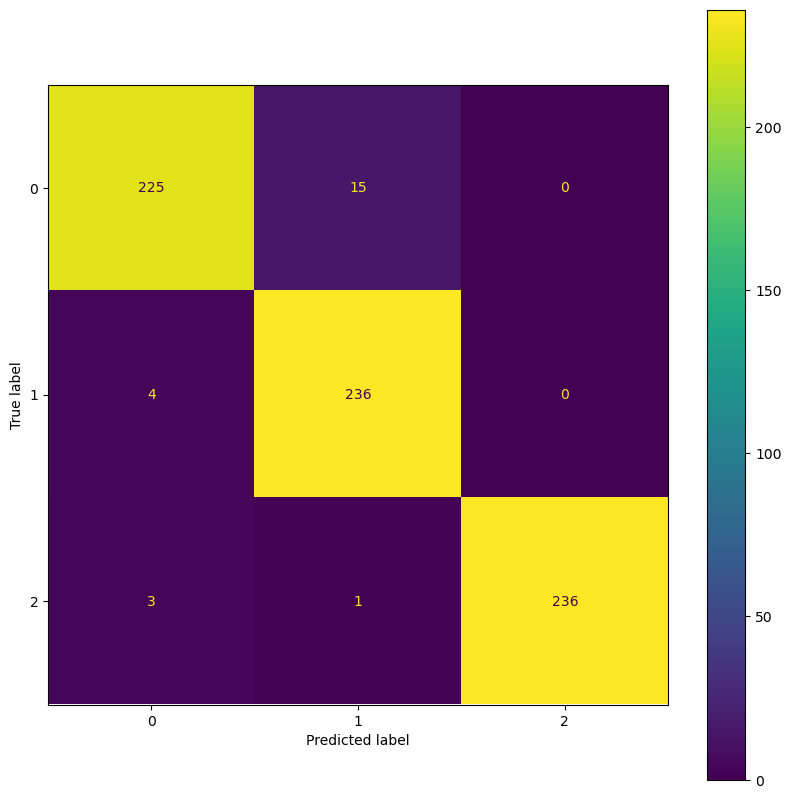

In [14]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(val_test_y, val_y_pred)

print("Confusion Matrix:")
print(cm)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()


In [7]:
import numpy as np
from scipy.stats import mode

def majority_voting(models, X):
    predictions = []
    for model in models:
        print(model)
        predictions.append(model.predict(X))
    return mode(np.vstack(predictions), axis=0)[0].flatten()
models = [clf_svc, clf_log, clf_knn, clf_random, clf_xgb]

val_y_pred = majority_voting(models, val_test_X)
val_accuracy = np.mean(val_y_pred == val_test_y)
print(f'Voting Classifier - Validation accuracy: {val_accuracy:.2f}')


SVC(kernel='linear', probability=True)
LogisticRegression(solver='liblinear')
KNeighborsClassifier()
RandomForestClassifier(n_jobs=-1)
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=42, ...)
Voting Classifier - Validation accuracy: 0.95


In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(val_test_y, val_y_pred)

print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[224  16   0]
 [ 13 226   1]
 [  0   6 234]]


# Adaboost=meta

In [13]:
from sklearn.ensemble import AdaBoostClassifier

final_estimator_ada = AdaBoostClassifier(n_estimators=50, random_state=42)
final_estimator_ada.fit(stacked_train_preds, train_y)

val_y_pred_ada = stacking_predictions(models, val_test_X, final_estimator_ada)
val_accuracy_ada = np.mean(val_y_pred_ada == val_test_y)
print(f'Stacking Classifier (AdaBoost) - Validation accuracy: {val_accuracy_ada:.2f}')


SVC(kernel='linear', probability=True)
LogisticRegression(solver='liblinear')
KNeighborsClassifier()
RandomForestClassifier(n_jobs=-1)
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=42, ...)
Stacking Classifier (AdaBoost) - Validation accuracy: 0.96


In [43]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(val_test_y, val_y_pred_ada)

print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[224  16   0]
 [  7 232   1]
 [  0   9 231]]


# Random forest = meta

In [17]:
from sklearn.ensemble import RandomForestClassifier

final_estimator_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
final_estimator_rf.fit(stacked_train_preds, train_y)

val_y_pred_rf = stacking_predictions(models, val_test_X, final_estimator_rf)
val_accuracy_rf = np.mean(val_y_pred_rf == val_test_y)
print(f'Stacking Classifier (Random Forest) - Validation accuracy: {val_accuracy_rf:.2f}')


SVC(kernel='linear', probability=True)
LogisticRegression(solver='liblinear')
KNeighborsClassifier()
RandomForestClassifier(n_jobs=-1)
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=42, ...)
Stacking Classifier (Random Forest) - Validation accuracy: 0.95


In [42]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(val_test_y, val_y_pred_rf)

print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[226  14   0]
 [ 13 227   0]
 [  0   7 233]]


# Gradient boost=meta

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

final_estimator_gb = GradientBoostingClassifier(n_estimators=50, random_state=42)
final_estimator_gb.fit(stacked_train_preds, train_y)

val_y_pred_gb = stacking_predictions(models, val_test_X, final_estimator_gb)
val_accuracy_gb = np.mean(val_y_pred_gb == val_test_y)
print(f'Stacking Classifier (Gradient Boosting) - Validation accuracy: {val_accuracy_gb:.2f}')


SVC(kernel='linear', probability=True)
LogisticRegression(solver='liblinear')
KNeighborsClassifier()
RandomForestClassifier(n_jobs=-1)
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=42, ...)
Stacking Classifier (Gradient Boosting) - Validation accuracy: 0.95


# Trying on the bigger test set

In [8]:
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input

train_dir = '/kaggle/input/clasificare2/clasificare2/train'
val_dir = '/kaggle/input/clasificare2/clasificare2/val'
test_dir = '/kaggle/input/classification-big-test/classification_big_test'

labels = ['very_good', 'good', 'poor']

#model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#from keras.applications.vgg16 import VGG16, preprocess_input
#model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
from keras.applications.resnet import ResNet50, preprocess_input
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

num_features = 50

train_features = []
train_class_labels = []
val_features = []
val_class_labels = []
test_features = []
test_class_labels = []

batch_size = 32

# for class_label, class_name in enumerate(labels):
#     for img_file in os.listdir(os.path.join(train_dir, class_name)):
#         if img_file.endswith('.png'):
#             img = load_img(os.path.join(train_dir, class_name, img_file), target_size=(224, 224))
#             x = img_to_array(img)
#             x = preprocess_input(x)

#             features_raw = model.predict(np.array([x]))
#             train_features.append(features_raw.flatten())

#             train_class_labels.append(class_label)

# for class_label, class_name in enumerate(labels):
#     for img_file in os.listdir(os.path.join(val_dir, class_name)):
#         if img_file.endswith('.png'):
#             img = load_img(os.path.join(val_dir, class_name, img_file), target_size=(224, 224))
#             x = img_to_array(img)
#             x = preprocess_input(x)

#             features_raw = model.predict(np.array([x]))
#             val_features.append(features_raw.flatten())

#             val_class_labels.append(class_label)

for class_label, class_name in enumerate(labels):
    for img_file in os.listdir(os.path.join(test_dir, class_name)):
        if img_file.endswith('.png'):
            img = load_img(os.path.join(test_dir, class_name, img_file), target_size=(224, 224))
            x = img_to_array(img)
            x = preprocess_input(x)

            features_raw = model.predict(np.array([x]))
            test_features.append(features_raw.flatten())

            test_class_labels.append(class_label)

# val_features, val_class_labels = extract_features_from_generator(val_generator, model, len(val_generator.filenames))
# test_features, test_class_labels = extract_features_from_generator(test_generator, model, len(test_generator.filenames))
# train_features, train_class_labels = extract_features_from_generator(train_generator, model, len(train_generator.filenames))


# train_X = np.array(train_features)
# train_y = np.array(train_class_labels)
# val_X = np.array(val_features)
# val_y = np.array(val_class_labels)
test_X = np.array(test_features)
test_y = np.array(test_class_labels)


1/1 [==============================] - 0s 26ms/step


In [9]:
selector = SelectFromModel(ExtraTreesClassifier(n_estimators=200, random_state=42), threshold='mean')
selector.fit(train_X, train_y)
# train_X_selected = selector.transform(train_X)
# val_X_selected = selector.transform(val_X)
big_test_X_selected = selector.transform(test_X)
# train_X_selected = train_X
# val_X_selected = val_X
# test_X_selected = test_X

# # Concatenate val and test
# val_test_X = np.concatenate((val_X_selected, test_X_selected), axis=0)
# val_test_y = np.concatenate((val_y, test_y), axis=0)

Using mobilenetv2: 
Logistic Regression - Validation accuracy: 0.80, Test accuracy: 0.78
k-Nearest Neighbors - Validation accuracy: 0.74, Test accuracy: 0.74
Random Forest Classifier - Validation accuracy: 0.81, Test accuracy: 0.79

Using VGG16:
Logistic Regression - 90
k-Nearest Neighbors - 87
Random Forest Classifier - 96
svm: 91

Using ResNet50:
Logistic Regression - Validation accuracy: 0.87, Test accuracy: 0.85
k-Nearest Neighbors - Validation accuracy: 0.83, Test accuracy: 0.84
Random Forest Classifier - Validation accuracy: 0.87, Test accuracy: 0.88

inception:
logreg: 88
knn: 84
random forest: 89
svm: 88

inception mean: 
logreg: 96
knn: 83
random forest: 92
svm: 95

VGG16 mean:
logreg: 92
knn: 72
random forest: 94
linear svm: 92

VGG16 median:
logreg: 91
knn: 73
random forest: 92
svm: 92

Resnet50 median:
logreg:
knn:
rand forest:
svm: 

In [10]:
# import numpy as np

# def stacking_predictions(models, X, final_estimator):
#     model_preds = []
#     for model in models:
#         print(model)
#         model_preds.append(model.predict_proba(X))
    
#     stacked_preds = np.hstack(model_preds)
    
#     final_preds = final_estimator.predict(stacked_preds)
    
#     return final_preds
# models = [clf_svc, clf_log, clf_knn, clf_random, clf_xgb]

# final_estimator = xgb.XGBClassifier(objective='multi:softprob', num_class=3, n_jobs=-1, seed=42)
# stacked_train_preds = np.hstack([model.predict_proba(train_X_selected) for model in models])
# final_estimator.fit(stacked_train_preds, train_y)
# val_y_pred = stacking_predictions(models, val_test_X, final_estimator)
# val_accuracy = np.mean(val_y_pred == val_test_y)
# print(f'Stacking Classifier - Validation accuracy: {val_accuracy:.2f}')

big_test_y_pred = stacking_predictions(models, big_test_X_selected, final_estimator)
val_accuracy = np.mean(test_y == big_test_y_pred)
print(f'Stacking Classifier - Validation accuracy: {val_accuracy:.2f}')

SVC(kernel='linear', probability=True)
LogisticRegression(solver='liblinear')
KNeighborsClassifier()
RandomForestClassifier(n_jobs=-1)
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=42, ...)
Stacking Classifier - Validation accuracy: 0.90


In [11]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, big_test_y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[310  89   1]
 [ 22 377   1]
 [  1   4 395]]


# Using the probabilities - xgboost meta

In [33]:
import numpy as np

def stacking_predictions(models, X, final_estimator):
    model_probs = []
    for model in models:
        model_probs.append(model.predict_proba(X))
    
    stacked_probs = np.hstack(model_probs)
    
    final_preds = final_estimator.predict(stacked_probs)
    
    return final_preds

models = [clf_svc, clf_log, clf_knn, clf_random, clf_xgb]

final_estimator = xgb.XGBClassifier(objective='multi:softprob', num_class=3, n_jobs=-1, seed=42)
stacked_train_probs = np.hstack([model.predict_proba(train_X_selected) for model in models])
final_estimator.fit(stacked_train_probs, train_y)

val_y_pred = stacking_predictions(models, val_test_X, final_estimator)
val_accuracy = np.mean(val_y_pred == val_test_y)
print(f'Stacking Classifier - Validation accuracy: {val_accuracy:.2f}')

big_test_y_pred = stacking_predictions(models, big_test_X_selected, final_estimator)
big_test_accuracy = np.mean(test_y == big_test_y_pred)
print(f'Stacking Classifier - Big Test accuracy: {big_test_accuracy:.2f}')


Stacking Classifier - Validation accuracy: 0.97
Stacking Classifier - Big Test accuracy: 0.90


In [34]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, big_test_y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[310  89   1]
 [ 22 377   1]
 [  1   4 395]]


# Adaboost = meta

In [14]:
from sklearn.ensemble import AdaBoostClassifier

# final_estimator_ada = AdaBoostClassifier(n_estimators=50, random_state=42)
# final_estimator_ada.fit(big_test_y_pred, train_y)

big_test_y_pred_ada = stacking_predictions(models, big_test_X_selected, final_estimator_ada)
val_accuracy_ada = np.mean(big_test_y_pred_ada == test_y)
print(f'Stacking Classifier (AdaBoost) - Validation accuracy: {val_accuracy_ada:.2f}')


SVC(kernel='linear', probability=True)
LogisticRegression(solver='liblinear')
KNeighborsClassifier()
RandomForestClassifier(n_jobs=-1)
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=42, ...)
Stacking Classifier (AdaBoost) - Validation accuracy: 0.89


In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, big_test_y_pred_ada)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[288 111   1]
 [ 20 379   1]
 [  0   5 395]]


on probabilities

In [35]:
big_test_y_pred = stacking_predictions(models, big_test_X_selected, final_estimator_ada)
big_test_accuracy = np.mean(test_y == big_test_y_pred)
print(f'Stacking Classifier - Big Test accuracy: {big_test_accuracy:.2f}')

Stacking Classifier - Big Test accuracy: 0.89


In [36]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, big_test_y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[288 111   1]
 [ 20 379   1]
 [  0   5 395]]


# Random forest = meta

In [18]:
from sklearn.ensemble import RandomForestClassifier

# final_estimator_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
# final_estimator_rf.fit(stacked_train_preds, train_y)

val_y_pred_rf = stacking_predictions(models, big_test_X_selected, final_estimator_rf)
val_accuracy_rf = np.mean(val_y_pred_rf == test_y)
print(f'Stacking Classifier (Random Forest) - Validation accuracy: {val_accuracy_rf:.2f}')


SVC(kernel='linear', probability=True)
LogisticRegression(solver='liblinear')
KNeighborsClassifier()
RandomForestClassifier(n_jobs=-1)
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=42, ...)
Stacking Classifier (Random Forest) - Validation accuracy: 0.86


In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, val_y_pred_rf)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[281 119   0]
 [ 38 361   1]
 [  0  12 388]]


probabilities

In [37]:
big_test_y_pred = stacking_predictions(models, big_test_X_selected, final_estimator_rf)
big_test_accuracy = np.mean(test_y == big_test_y_pred)
print(f'Stacking Classifier - Big Test accuracy: {big_test_accuracy:.2f}')

Stacking Classifier - Big Test accuracy: 0.86


In [38]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, big_test_y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[281 119   0]
 [ 38 361   1]
 [  0  12 388]]


In [24]:
# import numpy as np
# from scipy.stats import mode

# def majority_voting(models, X):
#     predictions = []
#     for model in models:
#         print(model)
#         predictions.append(model.predict(X))
#     return mode(np.vstack(predictions), axis=0)[0].flatten()
# models = [clf_svc, clf_log, clf_knn, clf_random, clf_xgb]

val_y_pred = majority_voting(models, big_test_X_selected)
val_accuracy = np.mean(val_y_pred == test_y)
print(f'Voting Classifier - Validation accuracy: {val_accuracy:.2f}')


SVC(kernel='linear', probability=True)
LogisticRegression(solver='liblinear')
KNeighborsClassifier()
RandomForestClassifier(n_jobs=-1)
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=42, ...)
Voting Classifier - Validation accuracy: 0.86


In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, val_y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[281 119   0]
 [ 37 362   1]
 [  0  12 388]]


# Gradient boost meta

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

# final_estimator_gb = GradientBoostingClassifier(n_estimators=50, random_state=42)
# final_estimator_gb.fit(stacked_train_preds, train_y)

val_y_pred_gb = stacking_predictions(models, big_test_X_selected, final_estimator_gb)
val_accuracy_gb = np.mean(val_y_pred_rf == test_y)
print(f'Stacking Classifier (Random Forest) - Validation accuracy: {val_accuracy_gb:.2f}')


SVC(kernel='linear', probability=True)
LogisticRegression(solver='liblinear')
KNeighborsClassifier()
RandomForestClassifier(n_jobs=-1)
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=42, ...)
Stacking Classifier (Random Forest) - Validation accuracy: 0.86


In [22]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, val_y_pred_gb)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[280 120   0]
 [ 38 360   2]
 [  0   9 391]]


# Model accuracies on the big test set

SVC - Test accuracy: 0.91


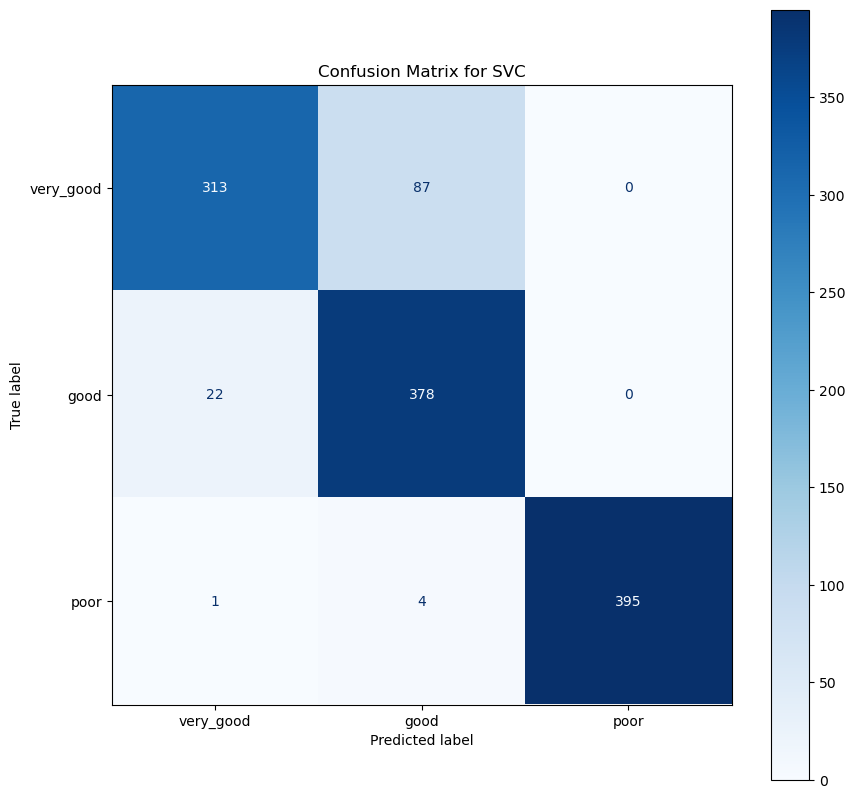

Logistic Regression - Test accuracy: 0.88


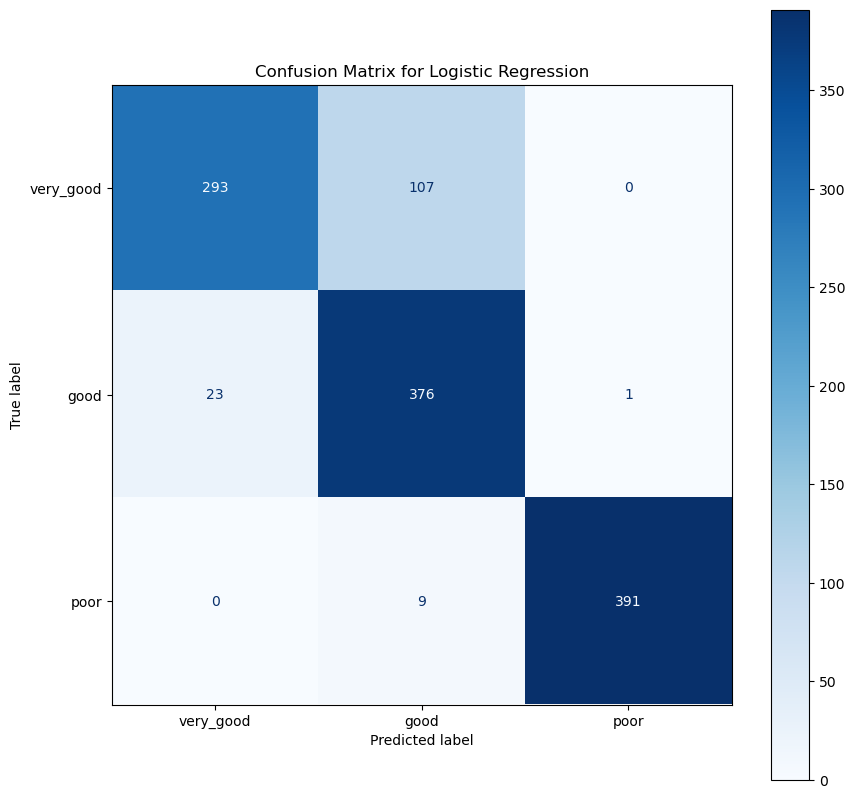

k-Nearest Neighbors - Test accuracy: 0.67


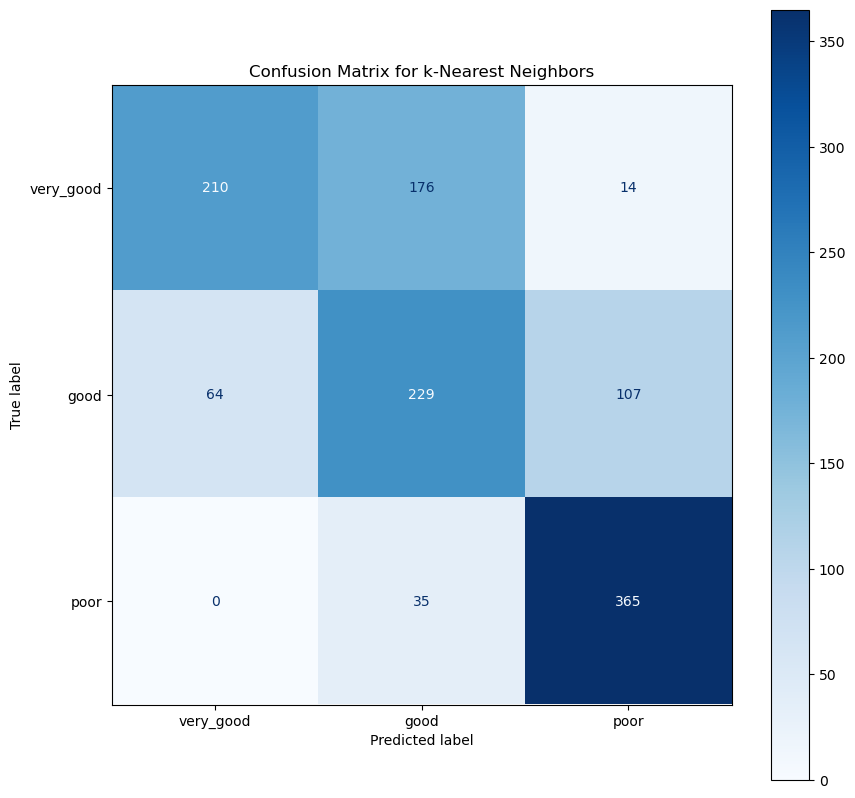

Random Forest Classifier - Test accuracy: 0.79


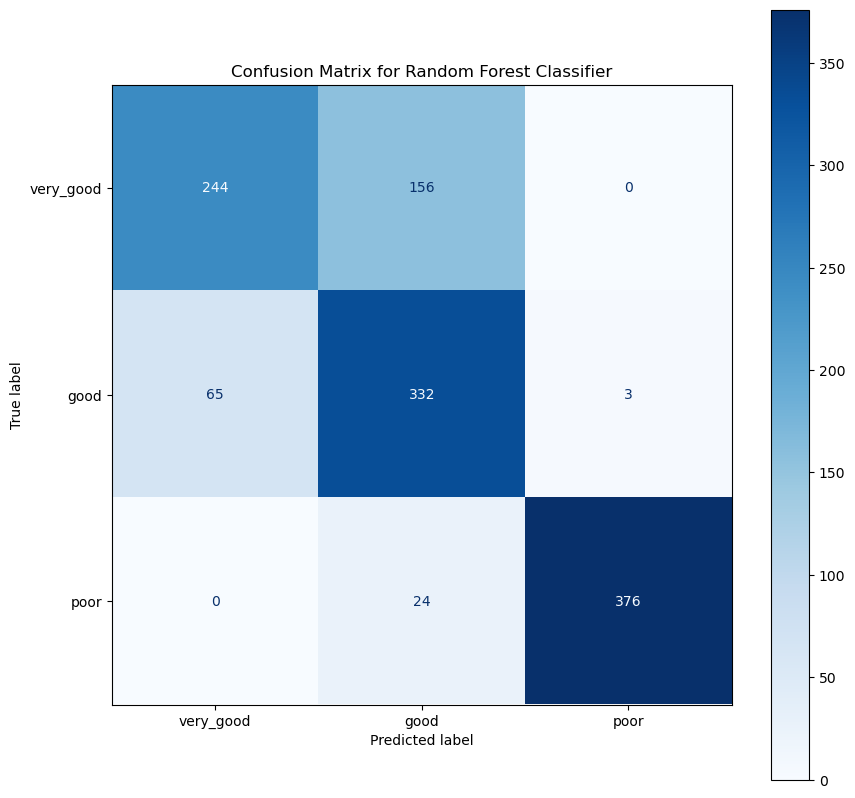

XGBoost - Test accuracy: 0.87


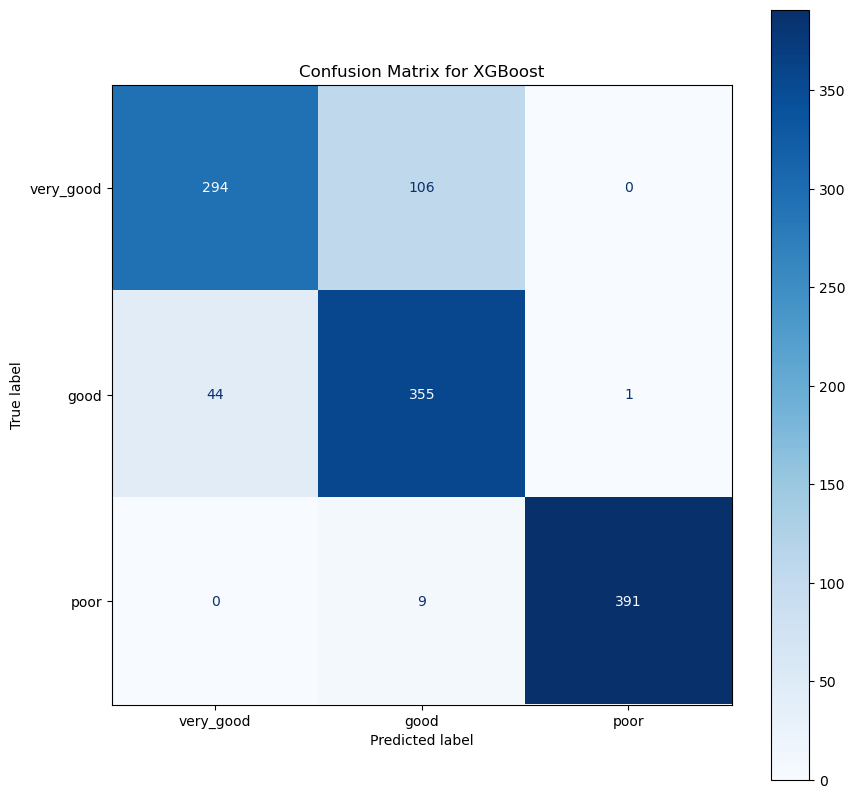

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models = [clf_svc, clf_log, clf_knn, clf_random, clf_xgb]
model_names = ['SVC', 'Logistic Regression', 'k-Nearest Neighbors', 'Random Forest Classifier', "XGBoost"]

for model, name in zip(models, model_names):
    second_test_y_pred = model.predict(big_test_X_selected)
    
    accuracy = np.mean(second_test_y_pred == test_y)
    print(f'{name} - Test accuracy: {accuracy:.2f}')

    cm = confusion_matrix(test_y, second_test_y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    plt.show()


# Soft voting 

Custom Soft Voting - Validation accuracy: 0.96
Custom Soft Voting - Second Test accuracy: 0.87


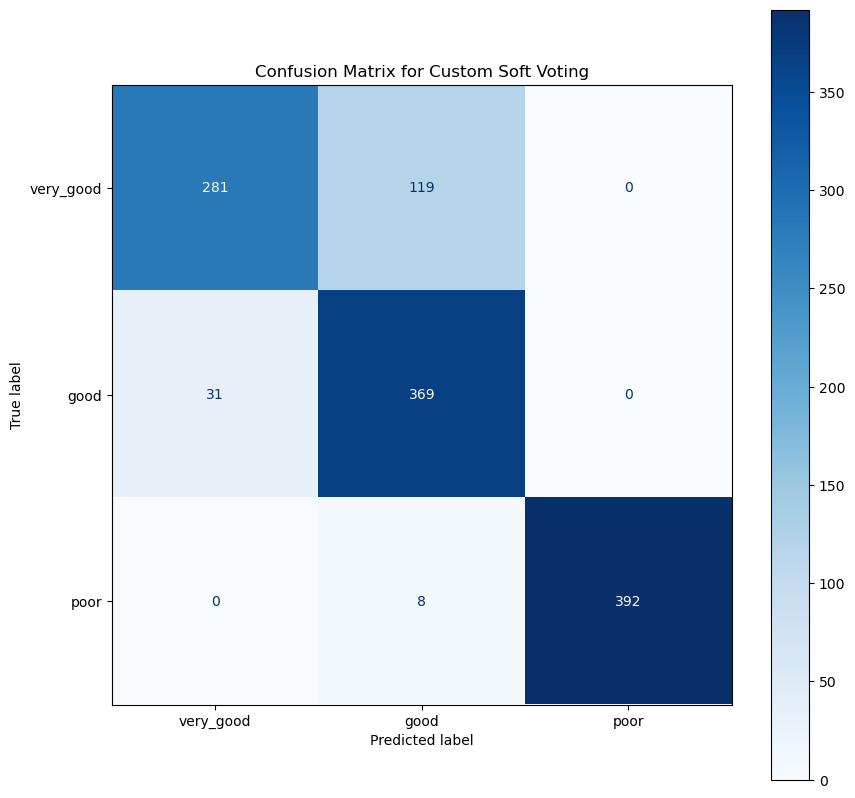

In [31]:
import numpy as np

def custom_soft_voting_predict(models, X):
    probas = np.asarray([model.predict_proba(X) for model in models])
    avg_probas = np.average(probas, axis=0)
    return np.argmax(avg_probas, axis=1)

models = [clf_svc, clf_log, clf_knn, clf_random, clf_xgb]
val_y_pred = custom_soft_voting_predict(models, val_test_X)
val_accuracy = np.mean(val_y_pred == val_test_y)
print(f'Custom Soft Voting - Validation accuracy: {val_accuracy:.2f}')

second_test_y_pred = custom_soft_voting_predict(models, big_test_X_selected)
second_test_accuracy = np.mean(second_test_y_pred == test_y)
print(f'Custom Soft Voting - Second Test accuracy: {second_test_accuracy:.2f}')

cm = confusion_matrix(test_y, second_test_y_pred)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Custom Soft Voting')
plt.show()
